# Competition — Link Prediction

### Challenge Overview

The dataset contains publications that is described by a binary vector indicating the presence of the corresponding word. The dateset can be represented as a graph where nodes are publications and edges are citations. For simplicity, let us say that this graph is undirected. The most similar pairs of nodes which are not connected was selected in the same amount as existent edges. The used proximity metric is cosine similarity, which is a normalized dot product of adjacency matrix. Let us denote existent edges by label 1 and additionally selected pairs by label 0.

The dataset is represented by 3 files:
* features.txt contains description of the papers in the format:
    * `<node id> <3703 unique one-hot encoded words>`
* labeled_edges.txt contains labeled pairs of nodes in the format:
    * `<node id> <node id> <label>`
* unlabeled_edges.txt contains unlabeled pairs of nodes in the format:
    * `<node id> <node id>`

Your task is to predict labels for unlabeled pairs of nodes: 0 — disconnected, 1 — connected.

Hints:
* Consider the features only. Transform the sparse feature matrix into low-dimensional dense embeddings. Fit a classificator to predict links.
* Consider the structure only. Create a graph that consists of edges with labels 1. Train any structural embedding model to obtain node embeddings. Fit a classificator to predict links.
* Consider the both structure and features. Create a graph that consists of edges with labels 0, labels 1 and no labels. Train any GNN model to obtain node embeddings. Minimize the link prediction error by gradient descent.
* Concatenate (multiply, sum up, average) pairs of node embeddings to obtain edge embeddings.
* You can combine embeddings from heterogeneous models.

### Evaluation Criteria

Here are balanced classes, so the usual accuracy metric is used:

* Accuracy = True predictions / All predictions

You can find baselines for grade 4, 6, 8 in the leaderboard.

### Submission Guidelines

Upload the txt file with your predictions sepateted by line break. For example:
```
1
1
0
1
0
```
... and so on.

In [251]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

import torch
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from zlib import adler32
from IPython.display import clear_output

In [6]:
features = np.fromfile("features.txt", sep="\n", dtype=int)

In [20]:
features = features.reshape(-1, 3704)
features.shape

(3312, 3704)

In [39]:
np.fromfile("unlabeled_edges.txt", sep="\n", dtype=int).reshape(-1, 2)

array([[1429, 2808],
       [1125, 1250],
       [2277, 2810],
       ...,
       [ 202,  387],
       [1284, 1017],
       [1958, 2407]])

In [22]:
labels = np.fromfile("labeled_edges.txt", sep="\n", dtype=int).reshape(-1, 3)
labels

array([[2495,  598,    0],
       [1473, 1570,    1],
       [1000,  748,    1],
       ...,
       [1816, 2097,    0],
       [ 218,  876,    0],
       [1985, 1657,    0]])

In [42]:
G = nx.Graph()

In [43]:
G.add_edges_from(labels[labels[:, 2] == 1, :2])

In [71]:
X = labels[labels[:, 2] == 1, :2]
train_edges, test_edges = train_test_split(X, random_state=7)

train_edges = list(map(tuple, train_edges))
test_edges = list(map(tuple, test_edges))

In [88]:
def sim_link_prediction(train_edges, test_edges):
    
    nodes = sorted(set(np.array(train_edges + test_edges).flatten()))
    train_edges = set(train_edges)
    test_edges = set(test_edges)
    
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(train_edges)
    
    y_true = []
    edges_to_rate = []
    
    for node_i in nodes:
        for node_j in nodes:
            if node_i >= node_j: continue
            if (node_i, node_j) in train_edges: continue
            y_true.append((node_i, node_j) in test_edges)
            edges_to_rate.append((node_i, node_j))
    
    res = []
    for index in tqdm([nx.jaccard_coefficient, 
                       nx.adamic_adar_index, 
                       nx.resource_allocation_index]):
        y_score = [p for u, v, p in tqdm(index(G, edges_to_rate), 
                                         total=len(edges_to_rate), 
                                         leave=False)]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        res.append((fpr, tpr))
    
    return res

In [89]:
jac, adam, res = sim_link_prediction(train_edges, test_edges)

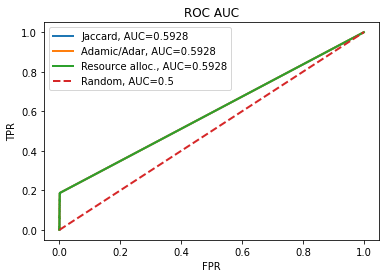

In [90]:
cases = [[jac[0], jac[1], 'Jaccard'], 
         [adam[0], adam[1], 'Adamic/Adar'], 
         [res[0], res[1], 'Resource alloc.']]
for fpr, tpr, label in cases:
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random, AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

In [113]:
def adamic_adar_similarity_matrix(train_edges):
    edges = np.array(train_edges)
    G_train = nx.Graph(train_edges)
    sim_matrix = np.zeros((edges.max() + 1, edges.max() + 1))
    for i, j, v in nx.adamic_adar_index(G_train):
        sim_matrix[i, j] = v
    return sim_matrix

In [167]:
adar_sim_matrix = adamic_adar_similarity_matrix(list(map(tuple, X)))

In [115]:
def inner_product_decoder(embeddings, test_edges):
    edges = np.array(test_edges)
    return (embeddings[edges[:, 0]] * embeddings[edges[:, 1]]).sum(axis=1)

In [168]:
# negatives = negative_sampling(train_edges, test_edges)

# np.random.seed(0)
# validation = np.array(negatives + test_edges)[np.random.permutation(len(negatives) + len(test_edges))]
# y_true = [int(tuple(i) in test_edges) for i in validation]

# negatives = negative_sampling(train_edges, test_edges)

negatives = list(map(tuple, labels[labels[:, 2] == 1, :2]))

np.random.seed(0)
validation = np.array(negatives + test_edges)[np.random.permutation(len(negatives) + len(test_edges))]
y_true = [int(tuple(i) in test_edges) for i in validation]

In [169]:
embeddings = TruncatedSVD(n_components=8).fit_transform(adar_sim_matrix)

scores = inner_product_decoder(embeddings, validation - 2)
tpr, fpr, _ = roc_curve(y_true, scores)
auc(fpr, tpr)

0.49459200562982164

In [170]:
def average_operator(G, embeddings, edges):
    E = []
    for edge in edges:
        E.append((embeddings[edge[0]] + embeddings[edge[1]]) / 2)
    return np.array(E)

def hadamard_operator(G, embeddings, edges):
    E = []
    for edge in edges:
        E.append(embeddings[edge[0]] * embeddings[edge[1]])
    return np.array(E)

def weighted_l1_operator(G, embeddings, edges):
    E = []
    for edge in edges:
        E.append(np.abs(embeddings[edge[0]] - embeddings[edge[1]]))
    return np.array(E)

def weighted_l2_operator(G, embeddings, edges):
    E = []
    for edge in edges:
        E.append((embeddings[edge[0]] - embeddings[edge[1]])**2)
    return np.array(E)

def neighbor_weighted_l1_operator(G, embeddings, edges):
    
    E = []
    for a, b in edges:
        
        neighbors_a = list(G.neighbors(a)) + [a]
        neighbors_b = list(G.neighbors(b)) + [b]
        
        E.append(
            np.abs(
                np.sum(embeddings[neighbors_a], axis=0) / len(neighbors_a) 
                - np.sum(embeddings[neighbors_b], axis=0) / len(neighbors_b)
            )
        )
        
    return np.array(E)

def neighbor_weighted_l2_operator(G, embeddings, edges):

    E = []
    for a, b in edges:
        
        neighbors_a = list(G.neighbors(a)) + [a]
        neighbors_b = list(G.neighbors(b)) + [b]
        
        E.append(
            np.power(
                np.sum(embeddings[neighbors_a], axis=0) / len(neighbors_a) 
                - np.sum(embeddings[neighbors_b], axis=0) / len(neighbors_b), 2
            )
        )
        
    return np.array(E)

In [171]:
np.unique(validation)

array([   0,    1,    2, ..., 3309, 3310, 3311])

In [174]:
G_train = nx.Graph()
G_train.add_nodes_from(np.arange(max(set(sum(train_edges, ())) | set(sum(test_edges, ())))))
G_train.add_edges_from(train_edges)
G_train.add_edges_from(test_edges)

operators = {
    "average_operator": average_operator,
    "hadamard_operator": hadamard_operator,
    "weighted_l1_operator": weighted_l1_operator,
    "weighted_l2_operator": weighted_l2_operator,
    "neighbor_weighted_l1_operator": neighbor_weighted_l1_operator,
    "neighbor_weighted_l2_operator": neighbor_weighted_l2_operator
}

train_split = int(len(validation) * 0.8)
res = {}
for nm, f in operators.items():
    lr = LogisticRegression()
    e = f(G_train, embeddings, validation)
    lr.fit(e[:train_split], y_true[:train_split])
    preds = lr.predict_proba(e[train_split:])[:, 1]
    fpr, tpr, _ = roc_curve(y_true[train_split:], preds)
    res[nm] = {
        'fpr': fpr,
        'tpr': tpr
    }

In [176]:
res

{'average_operator': {'fpr': array([0.        , 0.        , 0.00438596, 0.00438596, 0.00657895,
         0.00657895, 0.01315789, 0.01315789, 0.01315789, 0.01535088,
         0.01535088, 0.01754386, 0.01754386, 0.02850877, 0.02850877,
         0.02850877, 0.02850877, 0.03070175, 0.03070175, 0.03947368,
         0.03947368, 0.03947368, 0.05482456, 0.05482456, 0.06140351,
         0.06140351, 0.06359649, 0.06359649, 0.06578947, 0.06578947,
         0.08552632, 0.08552632, 0.09429825, 0.09429825, 0.09429825,
         0.10307018, 0.10307018, 0.10526316, 0.10526316, 0.10526316,
         0.10745614, 0.10745614, 0.11842105, 0.11842105, 0.12061404,
         0.12061404, 0.12280702, 0.12280702, 0.12938596, 0.12938596,
         0.13815789, 0.13815789, 0.14692982, 0.14692982, 0.14912281,
         0.14912281, 0.15131579, 0.15131579, 0.15350877, 0.15350877,
         0.15350877, 0.1622807 , 0.1622807 , 0.1754386 , 0.1754386 ,
         0.17763158, 0.17763158, 0.17982456, 0.17982456, 0.18640351,
       

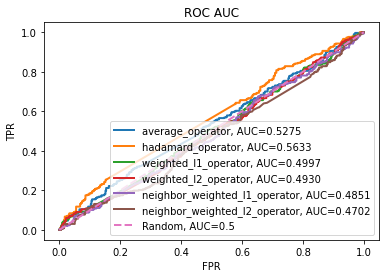

In [177]:
for label, v in res.items():
    fpr, tpr = v['fpr'], v['tpr']
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random, AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

In [153]:
features

array([[   0,    0,    0, ...,    0,    0,    0],
       [   1,    0,    0, ...,    0,    0,    0],
       [   2,    0,    1, ...,    0,    0,    0],
       ...,
       [3309,    0,    0, ...,    0,    0,    0],
       [3310,    0,    0, ...,    0,    0,    0],
       [3311,    0,    0, ...,    0,    0,    0]])

In [178]:
features

array([[   0,    0,    0, ...,    0,    0,    0],
       [   1,    0,    0, ...,    0,    0,    0],
       [   2,    0,    1, ...,    0,    0,    0],
       ...,
       [3309,    0,    0, ...,    0,    0,    0],
       [3310,    0,    0, ...,    0,    0,    0],
       [3311,    0,    0, ...,    0,    0,    0]])

In [179]:
labels

array([[2495,  598,    0],
       [1473, 1570,    1],
       [1000,  748,    1],
       ...,
       [1816, 2097,    0],
       [ 218,  876,    0],
       [1985, 1657,    0]])

In [214]:
features[2495]

array([2495,    0,    0, ...,    0,    0,    0])

In [225]:
dataset = []

for row in tqdm(labels):
    feats_ = features[row[0]].squeeze() + features[row[1]].squeeze()
    feats_ = feats_[1:].tolist()
    label_ = [row[2].tolist()]
    dataset.append(feats_ + label_)

In [230]:
dataset = pd.DataFrame(dataset)
dataset.shape

(6048, 3704)

In [231]:
dataset.iloc[:, :]

,0,1,2,3,4,5,6,7,8,9,...,3694,3695,3696,3697,3698,3699,3700,3701,3702,3703
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [244]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.1, random_state=7)

In [356]:
logreg = LogisticRegression(C=1e-4, max_iter=1000)
logreg.fit(X_train, y_train)
accuracy_score(y_train, logreg.predict(X_train)), accuracy_score(y_test, logreg.predict(X_test))

(0.6724232959764835, 0.6545454545454545)

In [252]:
accuracy_score(y_train, logreg.predict(X_train)), accuracy_score(y_test, logreg.predict(X_test))

(0.9303692816461511, 0.6016528925619835)

In [341]:
rfc = RandomForestClassifier(max_depth=29, random_state=7, n_jobs=-1)
rfc.fit(X_train, y_train)
accuracy_score(y_train, rfc.predict(X_train)), accuracy_score(y_test, rfc.predict(X_test))

(0.929083226162043, 0.7619834710743801)

In [342]:
rfc.fit(dataset.iloc[:, :-1], dataset.iloc[:, -1])

RandomForestClassifier(max_depth=29, n_jobs=-1, random_state=7)

In [343]:
unlabeled = np.fromfile("unlabeled_edges.txt", sep="\n", dtype=int).reshape(-1, 2)
unlabeled

array([[1429, 2808],
       [1125, 1250],
       [2277, 2810],
       ...,
       [ 202,  387],
       [1284, 1017],
       [1958, 2407]])

In [321]:
sub = []

for row in tqdm(unlabeled):
    feats_ = features[row[0]].squeeze() + features[row[1]].squeeze()
    feats_ = feats_[1:].tolist()
    sub.append(feats_)

In [322]:
sub = pd.DataFrame(sub)
sub.shape

(3024, 3703)

In [320]:
sub.head()

,0,1,2,3,4,5,6,7,8,9,...,3694,3695,3696,3697,3698,3699,3700,3701,3702,3703
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None


In [344]:
preds = rfc.predict(sub)

In [345]:
preds.tofile("submission.txt", sep="\n")

In [ ]:
# попробовать эмбеддинги word2vec

In [358]:
from gensim.models import Word2Vec

In [360]:
sub

,0,1,2,3,4,5,6,7,8,9,...,3693,3694,3695,3696,3697,3698,3699,3700,3701,3702
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [377]:
w2v = Word2Vec(sentences=X.astype(str).tolist(), size=50, workers=-1)

C:\Users\konqe\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


In [379]:
w2v.train(total_words=2715, epochs=10)

ModuleNotFoundError: No module named 'gensim.models.word2vec_corpusfile'

In [380]:
# you can use this function from last task from previous seminar
def random_walks(G, n_walks, path_length):
    # based on https://stackoverflow.com/questions/37311651/get-node-list-from-random-walk-in-networkx
    
    np.random.seed(40)
    
    A = nx.adj_matrix(G)
    A = A.todense()
    A = np.array(A, dtype=np.float32)
    # let's evaluate the degree matrix D
    D = np.diag(np.sum(A, axis=0))
    # ...and the transition matrix T
    P = np.dot(np.linalg.inv(D), A)
    # let's define the random walk length, say 10
    walkLength = path_length
    
    walks = []
    
    nodes = {v: k for k, v in enumerate(G.nodes)}
    
    # define the starting node, say the 0-th
    for node_name in nodes.keys():
        for _ in range(n_walks):            
            walk = []
            walk.append(node_name)
            for _ in range(walkLength - 1):
                # evaluate the next state vector
                prob = P[nodes[walk[-1]]]
#                 print(prob)
                # choose the node with higher probability as the visited node
                next_node_name = np.random.choice(list(nodes.keys()), p=prob)
                walk.append(next_node_name)
            walks.append(walk)
    return np.array(walks)

In [381]:
def make_skips(walk, length):
    
    skipped = []
    
    for i in range(length + 1):
        skipped_one_walk = walk[i::length]
        skipped.append(skipped_one_walk)
        
    return skipped

In [382]:
def make_skips_dataset(input_walks, length):
    
    dataset = []
    
    for walk in input_walks:
        dataset += make_skips(walk, length)
        
    return dataset

In [383]:
def train_embedding(nodes, walks, window_size=5, vector_size=8):
    
    nodes = sorted(nodes)
    
    skip_lengths = range(1, window_size + 1)
    
    N_nodes = len(nodes)
    N_skip_lengths = len(skip_lengths)
    
    embeddings = np.zeros((N_skip_lengths, N_nodes, vector_size), dtype=np.float32)
    
    for i, skip_length in tqdm(enumerate(skip_lengths), total=len(skip_lengths)):
        
        dataset = make_skips_dataset(walks.astype(str), length=skip_length)
        node2vec = Word2Vec(sentences=dataset, size=vector_size, min_count=1, sg=1, window=1, workers=-1)
        
        for j, node in enumerate(nodes):
            try:
                embeddings[i, j] = node2vec.wv[str(node)].squeeze()
            except:
                continue
    
    return embeddings.mean(axis=0)

In [400]:
np.random.seed(0)
G = nx.Graph(train_edges)
nodes = np.arange(max(set(sum(train_edges, ())) | set(sum(test_edges, ()))) + 1)
walks = random_walks(G, 10, 5)
embeddings = train_embedding(nodes, walks, vector_size=50)

C:\Users\konqe\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


In [516]:
dataset = []

for row in tqdm(labels):
    feats_ = np.concatenate((embeddings[row[0]].squeeze(), embeddings[row[1]].squeeze()))
    feats_ = feats_.tolist()
    label_ = [row[2].tolist()]
    dataset.append(feats_ + label_)
    
dataset = pd.DataFrame(dataset)

In [517]:
dataset.shape

(6048, 101)

In [518]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.1, random_state=7)

In [541]:
rfc = RandomForestClassifier(max_depth=7, random_state=7, n_jobs=-1)
rfc.fit(X_train, y_train)
accuracy_score(y_train, rfc.predict(X_train)), accuracy_score(y_test, rfc.predict(X_test))

(0.7738379570090024, 0.7735537190082644)

In [542]:
rfc.fit(dataset.iloc[:, :-1], dataset.iloc[:, -1])
preds = rfc.predict(pd.DataFrame(sub))

In [544]:
preds

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [543]:
preds.tofile("submission_emb_rfc.txt", sep="\n")

In [412]:
from xgboost import XGBClassifier

In [532]:
model = XGBClassifier(max_depth=5, n_estimators=10, reg_lambda=1, reg_alpha=7, n_jobs=-1)
model.fit(X_train, y_train)
accuracy_score(y_train, model.predict(X_train)), accuracy_score(y_test, model.predict(X_test))

[13:51:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.784677567517913, 0.775206611570248)

In [533]:
model.fit(dataset.iloc[:, :-1], dataset.iloc[:, -1])

[13:51:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=7, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [534]:
sub = []

for row in tqdm(unlabeled):
    feats_ = np.concatenate((embeddings[row[0]].squeeze(), embeddings[row[1]].squeeze()))
    feats_ = feats_.tolist()
    sub.append(feats_)

In [535]:
preds = model.predict(pd.DataFrame(sub))

In [536]:
preds.tofile("submission_emb_xgb_v2.txt", sep="\n")